# HTML Object Recognition

Yolo v3 model trained to recognize HTML buttons and implemented into .ipynb format using PyTorch.  Adapted from https://github.com/ydixon/yolo_v3.  In its current form, this model is missing lots of data.  It's supposed to recognize 17 different HTML objects: unknown, button, imagebutton, label, textbox, textarea, icon, chart, grid, tab, menu, treeview, radiobutton, listbox, dropdown, window, toolbar.  Due to the difficulty of annotating thousands of images, the current weights file only predicts buttons.  The next steps will be to create annotations for all object classes and retrain a weights file (that's your problem, sorry).  Here is a good resource for annotating and training: https://github.com/AlexeyAB/darknet#how-to-compile-on-windows.  


____

## Environment Setup

Installs essential packages and imports them for use within the program.  It also assigns locations for the weights and names files.  These two files will be replaced if more data is added.

Anchor: /home/dsxuser/work  (standard workspace in Watson Studio notebook)

In [1]:
!pip install opencv-python
!conda install pytorch-cpu torchvision-cpu -c pytorch
!conda install torchvision

    100% |████████████████████████████████| 25.0MB 38kB/s eta 0:00:011
Requirement not upgraded as not directly required: numpy>=1.11.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from opencv-python)
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    ninja:           1.8.2-py35h6bb024c_1        
    pytorch-cpu:     0.4.1-py35_cpu_1     pytorch
    torchvision-cpu: 0.2.1-py35_1         pytorch

ninja-1.8.2-py 100% |################################| Time: 0:00:00  17.27 MB/s
pytorch-cpu-0. 100% |################################| Time: 0:00:12   4.59 MB/s
torchvision-cp 100% |################################| Time: 0:00:00  57.20 MB/s
Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALL

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
#CUDA is currently false because Watson Studio can't handle it.  If this model
#is ever adapted to a local format, CUDA can be enabled to speed up predictions.

CUDA = False
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
weight_path = 'yolov3-custom_1000.weights'
names_path = 'obj.names'

_____

## Download weights

Checks if .weight path exists and loads a .names file.

In [4]:
import urllib.request
if not osp.exists(weight_path):
    print("Couldn't load custom weights file")

Couldn't load custom weights file


In [5]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [6]:
classes = load_coco(names_path)

_____

## Preprocessing

Transformations and standaridization.  Also loads the image that will be processed.

In [7]:
def letterbox_transforms(inner_dim, outer_dim):
    outer_w, outer_h = outer_dim
    inner_w, inner_h = inner_dim
    ratio = min(outer_w / inner_w, outer_h / inner_h)
    box_w = int(inner_w * ratio)
    box_h = int(inner_h * ratio)
    box_x_offset = (outer_w // 2) - (box_w // 2)
    box_y_offset = (outer_h // 2) - (box_h // 2)
    return box_w, box_h, box_x_offset, box_y_offset, ratio

In [8]:
def letterbox_image(img, dim):
    #Create the background
    image = np.full(dim +(3,), 128)
        
    img_dim = (img.shape[1], img.shape[0])
    box_w, box_h, box_x, box_y, ratio = letterbox_transforms(img_dim, dim)
    box_image = cv2.resize(img, (box_w,box_h), interpolation = cv2.INTER_CUBIC)
        
    #Put the box image on top of the blank image
    image[box_y:box_y+box_h, box_x:box_x+box_w] = box_image
        
    return image, (box_w, box_h, box_x, box_y, ratio)

In [9]:
# Mode - letterbox, resize
def load_image(img_path, mode=None, dim=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    trans = None
    if mode is not None and dim is not None:
        if mode == 'letterbox':
            img, trans = letterbox_image(img, dim)
        elif mode == 'resize':
            img = cv2.resize(img, dim)
    
    img = torch.from_numpy(img).float().permute(2,0,1) / 255
    return img, trans

____

## Network Building Blocks

Convolutional BN Relu and Res layers that will make up most of the network.

In [10]:
class conv_bn_relu(nn.Module):
    def __init__(self, nin, nout, ks, s=1, pad='SAME', padding=0, bn=True, act="leakyRelu"):
        super().__init__()
        
        self.bn = bn
        self.act = act
                
        if pad == 'SAME':
            padding = (ks - 1) // 2
            
        self.conv = nn.Conv2d(nin, nout, ks, s, padding, bias=not bn)
        if bn == True:
            self.bn = nn.BatchNorm2d(nout)
        if act == "leakyRelu":
            self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class res_layer(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.conv1 = conv_bn_relu(nin, nin//2, ks=1)
        self.conv2 = conv_bn_relu(nin//2, nin, ks=3)
        
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

______

## Map2cfgDict

I think this function works the same way .cfg files work for the official version of darknet.  For those uninitiated, .cfg files determine the architecture of the neural network.  Or it might allocate the .weights file correctly to the detection layers maybe, I'm not 100% sure.  For those more initiated than me, please fix this sorry excuse for documentation.

In [11]:
def map2cfgDict(mlist):
    idx = 0
    mdict = OrderedDict()
    for i,m in enumerate(mlist):
        if isinstance(m, res_layer):
            mdict[idx] = None
            mdict[idx+1] = None
            idx += 2
        mdict[idx] = i
        idx += 1
    return mdict

______

## Darknet53 Features

Extracts features, 53 times.  Just kidding.

In [12]:

def make_res_stack(nin, num_blk):
    return nn.ModuleList([conv_bn_relu(nin, nin*2, 3, s=2)] \
           + [res_layer(nin*2) for n in range(num_blk)])

class Darknet(nn.Module):
    def __init__(self, blkList, nout=32):
        super().__init__()
        self.mlist = nn.ModuleList()
        self.mlist += [conv_bn_relu(3, nout, 3)]
        for i,nb in enumerate(blkList):
            self.mlist += make_res_stack(nout*(2**i), nb)
            
        self.map2yolocfg = map2cfgDict(self.mlist)
        self.cachedOutDict = dict()
        
    def forward(self,x):
        for i,m in enumerate(self.mlist):
            x = m(x)
            if i in self.cachedOutDict:
                self.cachedOutDict[i] = x
        return x
    
    #mode - normal  -- direct index to mlist
    #     - yolocfg -- index follow the sequences of the cfg file from https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
    def addCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idxs = self.map2yolocfg[idx]
        self.cachedOutDict[idxs] = None
        
    def getCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idxs = self.map2yolocfg[idx]
        return self.cachedOutDict[idxs]

___

##  Pre Detection Convolutional Group

Convolutional layers that come before yolo detection layers

In [13]:
class PreDetectionConvGroup(nn.Module):
    def __init__(self, nin, nout, num_conv=3):
        super().__init__()
        self.mlist = nn.ModuleList()
        
        for i in range(num_conv):
            self.mlist += [conv_bn_relu(nin, nout, ks=1)]
            self.mlist += [conv_bn_relu(nout, nout*2, ks=3)]
            if i == 0:
                nin = nout*2
                
        self.mlist += [nn.Conv2d(nin, 255, 1)]
        self.map2yolocfg = map2cfgDict(self.mlist)
        self.cachedOutDict = dict()
        
    def forward(self,x):
        for i,m in enumerate(self.mlist):
            x = m(x)
            if i in self.cachedOutDict:
                self.cachedOutDict[i] = x
        return x
    
    #mode - normal  -- direct index to mlist 
    #     - yolocfg -- index follow the sequences of the cfg file from https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
    def addCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idx = self.getIdxFromYoloIdx(idx)
        elif idx < 0:
            idx = len(self.mlist) - idx
        
        self.cachedOutDict[idx] = None
        
    def getCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idx = self.getIdxFromYoloIdx(idx)
        elif idx < 0:
            idx = len(self.mlist) - idx
        return self.cachedOutDict[idx]
    
    def getIdxFromYoloIdx(self,idx):
        if idx < 0:
            return len(self.map2yolocfg) + idx
        else:
            return self.map2yolocfg[idx]

_____

## Upsample Group

Takes features from high res layers and concatenates with upsampled feature maps

In [14]:
class UpsampleGroup(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.conv = conv_bn_relu(nin, nin//2, ks=1)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        
    def forward(self, route_head, route_tail):
        out = self.up(self.conv(route_head))
        return torch.cat((out, route_tail), 1)

___

## Yolo Detection Layers

In [15]:
class YoloLayer(nn.Module):
    def __init__(self, anchors, numClass):
        super().__init__()
        self.anchors = torch.Tensor(anchors).to(device)
        self.numClass = numClass
        
        #self.mlist = nn.ModuleList()
        #self.det = [conv_bn_relu(3, 4, 3)]
        #self.mlist += self.det
        
    def forward(self, x, img_dim):
        grid_size = x.shape[-1]
        numBBoxAttrib = 5 + self.numClass
        numAnchors = len(self.anchors)
        stride = img_dim // grid_size
        
        #Reshape the feature map from [batch x channel x grid_w x grid_h] to [batch x boundingbox x box attributes]
        x = x.permute(0,2,3,1).contiguous().view(-1, grid_size*grid_size*numAnchors, numBBoxAttrib)
        
        #Sigmoid tx,ty,to
        x[:,:,:2] = x[:,:,:2].sigmoid()
        x[:,:,4] = x[:,:,4].sigmoid()
        
        #Add cx,cy to sig(tx),sig(ty) , create cx,cy creating meshgrid of "grid_size"
        x_offset = torch.arange(grid_size).view(1,-1,1,1).repeat(grid_size,1,numAnchors,1).view(grid_size*grid_size*numAnchors, 1)
        y_offset = torch.arange(grid_size).view(-1,1,1,1).repeat(1,grid_size,numAnchors,1).view(grid_size*grid_size*numAnchors, 1)
        mesh = torch.cat((x_offset,y_offset), 1)
        mesh = mesh.float()
        x[:,:,:2] = x[:,:,:2].add(mesh.to(device))
        
        #Rescale anchors to fit the stride, multiply it by e^(tw) and e^(th)
        x[:,:,2:4] = torch.exp(x[:,:,2:4]).mul(self.anchors.div(stride).repeat(grid_size**2,1))
        
        #Sigmoid class scores
        x[:,:,5:] = x[:,:,5:].sigmoid()
        
        #Rescale bx,by,bw,bh by stride to orginal image size
        x[:,:,:4] *= stride
                
        return x

___

## Full network

In [16]:
class YoloNet(nn.Module):
    def __init__(self, anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326]):
        super().__init__()
        nin = 32
        numClass = 80
        
        anchors = [(anchors[i], anchors[i+1]) for i in range(0,len(anchors),2)]
        anchors = [anchors[i:i+3] for i in range(0, len(anchors), 3)][::-1]
                
        self.feature = Darknet([1,2,8,8,4])
        self.feature.addCachedOut(61)
        self.feature.addCachedOut(36)
        
        self.pre_det1 = PreDetectionConvGroup(1024, 512)
        self.yolo1 = YoloLayer(anchors[0], numClass)
        self.pre_det1.addCachedOut(-3) #Fetch output from 4th layer backward including yolo layer
        
        self.up1 = UpsampleGroup(512)
        self.pre_det2 = PreDetectionConvGroup(768, 256)
        self.yolo2 = YoloLayer(anchors[1], numClass)
        self.pre_det2.addCachedOut(-3)
        
        self.up2 = UpsampleGroup(256)
        self.pre_det3 = PreDetectionConvGroup(384, 128)
        self.yolo3 = YoloLayer(anchors[2], numClass)
        
    def forward(self,x):
        #Get image dimension
        img_size = x.shape[-1]
        
        #Extract features
        out = self.feature(x)
                
        #Detection layer 1
        out = self.pre_det1(out)
        det1 = self.yolo1(out, img_size)
        
        #Upsample 1
        r_head1 = self.pre_det1.getCachedOut(-3)
        r_tail1 = self.feature.getCachedOut(61)
        out = self.up1(r_head1,r_tail1)
                
        #Detection layer 2
        out = self.pre_det2(out)
        det2 = self.yolo2(out, img_size)
        
        #Upsample 2
        r_head2 = self.pre_det2.getCachedOut(-3)
        r_tail2 = self.feature.getCachedOut(36)
        out = self.up2(r_head2,r_tail2)
                
        #Detection layer 3
        out = self.pre_det3(out)
        det3 = self.yolo3(out, img_size)
        
        return det1,det2,det3
    
    def loadWeight(self, weights_path):
        wm = WeightManager(self)
        wm.loadWeight(weights_path)

___

## Weight loader

Loads weight file specified in the beginning

In [17]:
class WeightManager:
    def __init__(self, model):
        super().__init__()
        self.conv_list = self.find_conv_layers(model)

    def loadWeight(self, weight_path):
        ptr = 0
        weights = self.read_file(weight_path)
        print(len(weights))
        for m in self.conv_list:
            if type(m) == conv_bn_relu:
                ptr = self.load_conv_bn_relu(m, weights, ptr)
            elif type(m) == nn.Conv2d:
                ptr = self.load_conv2D(m, weights, ptr)
        return ptr
                
    def read_file(self, file):
        with open(file, "rb") as fp:
            header = np.fromfile(fp, dtype = np.int32, count = 5)
            self.header = torch.from_numpy(header)
            self.seen = self.header[3]
            weights = np.fromfile(fp, dtype = np.float32)
        return weights
    
    def copy_weight_to_model_parameters(self, param, weights, ptr):
        num_el = param.numel()
        param.data.copy_(torch.from_numpy(weights[ptr:ptr + num_el])
                             .view_as(param.data))
        return ptr + num_el
    
    def load_conv_bn_relu(self, m, weights, ptr):
        ptr = self.copy_weight_to_model_parameters(m.bn.bias, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.weight, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.running_mean, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.running_var, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.conv.weight, weights, ptr)
        return ptr
        
    def load_conv2D(self, m, weights, ptr):
        ptr = self.copy_weight_to_model_parameters(m.bias, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.weight, weights, ptr)
        return ptr
        
    def find_conv_layers(self, mod):
        module_list = []
        for m in mod.children():
            if type(m) == conv_bn_relu:
                module_list += [m]
            elif type(m) == nn.Conv2d:
                module_list += [m]
            elif isinstance(m, (nn.ModuleList, nn.Module)):
                module_list += self.find_conv_layers(m)
            elif type(m) == res_layer:
                module_list += self.find_conv_layers(m)
        return module_list

In [18]:
net = YoloNet().to(device).eval()
net.loadWeight(weight_path)

62001757


In [20]:
#This cell can be troublesome because it uses lots of computing power.  The online
#deployment should be pretty stable, but it can cause Watson Studio to crash.
#Of course if you're reading this that means it's no longer in the online 
#deployment.  If it fails, run this notebook again without the install cells.

#img_path needs to take an input image from the user

img_path = ("button_test.png")
resolution = 416
testData, trans = load_image(img_path, mode='letterbox', dim=(resolution, resolution))
testData = testData.unsqueeze(0).to(device)
det1,det2,det3 = net(testData)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


(torch.Size([1, 507, 85]),
 torch.Size([1, 2028, 85]),
 torch.Size([1, 8112, 85]))

___

## Helper functions

Help find unique values in tensor

In [21]:
def torch_unique(inp, CUDA=True):
    if CUDA:
        inp_cpu = inp.detach().cpu()
    
    res_cpu = torch.unique(inp_cpu)
    res = inp.new(res_cpu.shape)
    res.copy_(res_cpu)
    
    return res

In [22]:
def unqiue_with_order(inp, CUDA=True):
    if CUDA:
        inp_np = inp.detach().cpu().numpy()
    
    _, idx = np.unique(inp, return_index=True)
    result = inp_np[np.sort(idx)]
    result_tensor = torch.from_numpy(result)
    res = inp.new(result_tensor.shape)
    res.copy_(result_tensor)
    return res

____

## IOU and Non-max Suppression

Calculates overlap between boxes and makes sure multiple boxes aren't predicting the same object.  

In [23]:
def iou_vectorized(bbox):
    num_box = bbox.shape[0]
    
    bbox_leftTop_x =  bbox[:,0]
    bbox_leftTop_y =  bbox[:,1]
    bbox_rightBottom_x = bbox[:,2]
    bbox_rightBottom_y = bbox[:,3]
    
    inter_leftTop_x     =  torch.max(bbox_leftTop_x.unsqueeze(1).repeat(1,num_box), bbox_leftTop_x)
    inter_leftTop_y     =  torch.max(bbox_leftTop_y.unsqueeze(1).repeat(1,num_box), bbox_leftTop_y)
    inter_rightBottom_x =  torch.min(bbox_rightBottom_x.unsqueeze(1).repeat(1,num_box), bbox_rightBottom_x)
    inter_rightBottom_y =  torch.min(bbox_rightBottom_y.unsqueeze(1).repeat(1,num_box), bbox_rightBottom_y)
    
    inter_area = torch.clamp(inter_rightBottom_x - inter_leftTop_x, min=0) * torch.clamp(inter_rightBottom_y - inter_leftTop_y, min=0)
    bbox_area = (bbox_rightBottom_x - bbox_leftTop_x) * (bbox_rightBottom_y - bbox_leftTop_y)
    union_area = bbox_area.expand(num_box,-1) + bbox_area.expand(num_box,-1).transpose(0, 1) - inter_area
    
    iou = inter_area / union_area
    return iou

#Iterate through the bounding boxes and remove rows accordingly
def reduce_row_by_column(inp):
    i = 0
    while i < inp.shape[0]:
        remove_row_idx = inp[i][1].item()
        if inp[i][0] != remove_row_idx and i < inp.shape[0]:
            keep_mask = (inp[:,0] != remove_row_idx).nonzero().squeeze()
            inp = inp[keep_mask]
        i += 1
    return inp

#bbox is expected to be sorted by class score in descending order
def nms(bbox, iou, nms_thres):
    #Create a mapping that indicates which row has iou > threshold
    remove_map = (iou > nms_thres).nonzero()
    remove_map = reduce_row_by_column(remove_map)
    
    remove_idx = torch_unique(remove_map[:,0])
    res_bbox = bbox[remove_idx]
    
    return res_bbox

____

## Post-processing

Convert predictions to bounding boxes

In [24]:
def postprocessing(detections, num_classes, obj_conf_thr=0.5, nms_thr=0.4):
    #Zero bounding box with objectioness confidence score less than threshold 
    obj_conf_filter = (detections[:,:,4] > obj_conf_thr).float().unsqueeze(2)
    detections = detections * obj_conf_filter
           
    #Transform bounding box coordinates to two corners
    box = detections.new(detections[:,:,:4].shape)
    box[:,:,0] = detections[:,:,0] - detections[:,:,2]/2
    box[:,:,1] = detections[:,:,1] - detections[:,:,3]/2
    box[:,:,2] = box[:,:,0] + detections[:,:,2]
    box[:,:,3] = box[:,:,1] + detections[:,:,3]
    detections[:,:,:4] = box
    
    num_batches = detections.shape[0]
    results = torch.Tensor().to(device)
    
    for b in range(num_batches):
        batch_results = torch.Tensor().to(device)
        img_det = detections[b]
        
        
        max_class_score, max_class_idx= torch.max(img_det[:,5:5 + num_classes], 1)
        img_det = torch.cat((img_det[:,:5],
                             max_class_score.float().unsqueeze(1),
                             max_class_idx.float().unsqueeze(1)
                            ), 1)
        #img det - [b1_x, b1_y, b2_x, b2_y, obj_conf, class_score, class]
        
        #Remove zeroed rows
        nonzero_idx =  img_det[:,4].nonzero()
        img_det = img_det[nonzero_idx,:].view(-1,7)
        
        if img_det.shape[0] != 0:
            #Get the classes
            img_classes = torch_unique(img_det[:,-1])
            for c in img_classes:
                # Select rows with "c" class and sort by the class score
                class_img_det = img_det[(img_det[:,-1] == c).nonzero().squeeze()]
                # If there is only one detection, it will return a 1D tensor. Therefore, we perform a view to keep it in 2D
                class_img_det = class_img_det.view(-1, 7)
                #Sort by objectness score
                _, sort_idx = class_img_det[:,4].sort(descending=True)
                class_img_det = class_img_det[sort_idx]

                iou = iou_vectorized(class_img_det)
                #Alert: There's another loop operation in nms function
                class_img_det = nms(class_img_det, iou, nms_thr)
                batch_results = torch.cat((batch_results, class_img_det), 0)

            num_dets = batch_results.shape[0]
            batch_col = results.new_full((num_dets, 1), b)
            batch_results = torch.cat((batch_col, batch_results), 1)
            results = torch.cat((results, batch_results), 0)
    
    return results

In [25]:
detections = torch.cat((det1,det2,det3), 1)
pdet = postprocessing(detections, 80, obj_conf_thr=0.5)

(torch.Size([1, 10647, 85]), torch.Size([3, 8]))

____
why are these lines sometimes light and sometimes dark??

## Draw boxes onto image

In [27]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [28]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [29]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=0.5))
    draw_outline(patch, 2)

In [30]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [31]:
def bbox_plt(box):
    bx, by = box[0], box[1]
    bw = box[2] - box[0]
    bh = box[3] - box[1]
    return [bx, by, bw, bh]

In [32]:
def show_output(img, dets):
    ax = show_img(img, figsize=(16,8))
    for d in dets:
        draw_rect(ax, bbox_plt(d))
        c = classes[d[-1].int().item()]
        draw_text(ax, d[:2], c)

____

## Display predictions

In [5]:
#I commented out this part because it prints the image in a standardized
#resolution.  A later function prints the original resolution so it would 
#be redundant to keep this one implemented.  It wasn't removed altogether
#however because there may be some use for this in the future.

#show_output(testData.squeeze(0).permute(1,2,0), pdet[:,1:])

____

## Revert to original dimensions

In [34]:
#load the original image with no letterbox
img, _ = load_image("button_test.png")
img = img.permute(1,2,0)

In [35]:
def bbox_transform(box, x_max, y_max, x_offset, y_offset, ratio):
    box[:,[0,2]] = torch.clamp((box[:,[0,2]] - x_offset) / ratio, 0, x_max)
    box[:,[1,3]] = torch.clamp((box[:,[1,3]] - y_offset) / ratio, 0, y_max)
    return box

In [36]:
#trans is returned from the load_image call when we first input the letterboxed image into the network
box = pdet[:, 1:5]
box = bbox_transform(box, img.shape[1], img.shape[0], *trans[-3:])

tensor([[ 97.1325, 160.5146, 251.4537, 414.0553],
        [127.2149,  92.8158, 444.2950, 344.2939],
        [374.1214,  67.3819, 538.0682, 132.8284]],
       grad_fn=<AsStridedBackward>)

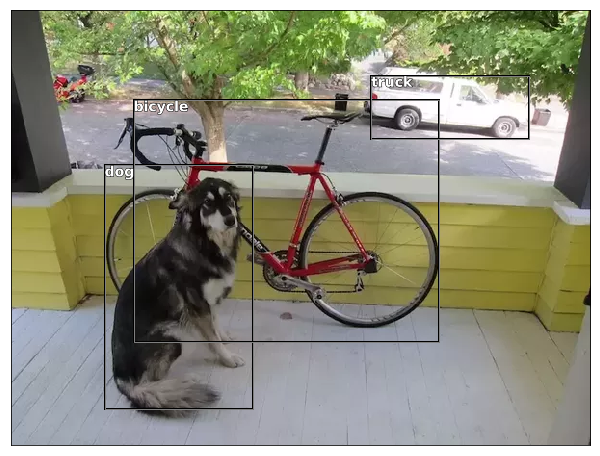

In [39]:
show_output(img, pdet[:,1:])

If you have questions, comments, or just want to vent, email me at brant.verlinde@gmail.com